## Project 2018 - "Programming For Data Analysis"

### A Notebook by: Marco Men

### Date Of Last Commit: 14th December 2018

## Introduction

In this notebook I will be choosing a  real-world phenomenon ( stock price fluctuations ) that can be measured and for which I can collect at least 100 data points ( based on closing stock prices and respective returns ) across at least four different variables ( 2 ficticious companies ).
The code used is adapted from 'Numpy - Beginner's guide ( Third Edition ) by Ivan Idris.
I will investigate the types of variables involved(their distributions and relationships with each other)
I will simulate/synthesise the dataset as closely matching their properties as possible.
I will also detail my research and implement the simulation in this Jupyter notebook

https://realpython.com/python-random/


The section below was extracted from https://www.quantconnect.com/tutorials/introduction-to-financial-python/random-variables-and-distributions on Amazon stock prices movement.
This website also provided some useful information regarding distributions in which stock prices movements appear to be based. I choose numpy.random.randn() for my simulation as it was the one that appeared to be the most appropriate.

When I see information regarding stocks, the fluctuations are in between the 3 % range(up or down ) or 0%(no movement).
Of course, not all companies behave like this. I am not considering outliers. But the basic assumption I make is that if a company is listed(in a regulated jurisdiction,let's say FTSE or NYE ) there is usually some increased oversight. Directors are made accountable for their actions.
Amazon seemed to be a good benchmark company for my simulations.

In [5]:
import quandl
import pandas as pd 
import numpy as np
import datetime
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, cross_validation, svm




In [4]:
# https://stackoverflow.com/questions/49705047/downloading-mutliple-stocks-at-once-from-yahoo-finance-python

import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

yf.pdr_override()




tickers = ['^GSPC']

start_date = '2000-01-01'
end_date = '2018-09-30'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = pdr.get_data_yahoo(tickers,start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 downloaded


In [6]:
panel_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4716 entries, 2000-01-03 to 2018-09-28
Data columns (total 6 columns):
Open         4716 non-null float64
High         4716 non-null float64
Low          4716 non-null float64
Close        4716 non-null float64
Adj Close    4716 non-null float64
Volume       4716 non-null int32
dtypes: float64(5), int32(1)
memory usage: 239.5 KB


In [8]:
import pandas as pd

# Get S&P 500 index from wikipedia web scrapping 
# From: 'https://medium.com/python-data/how-to-scrape-information-of-s-p-500-listed-companies-with-python-8205f895ee7a'

data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
SP500 = data[0]
SP500.head()


,0,1,2,3,4,5,6,7,8
0,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Location,Date first added[3][4],CIK,Founded
1,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,0000066740,1902
2,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,0000001800,1888
3,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888)
4,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,0000815094,1981


In [6]:
SP500=quandl.get("BCIP/_SSHX", authtoken="ymZaXRszuj9PCW7wEcS3", start_date="2000-01-01", end_date="2018-01-01")



ForbiddenError: (Status 403) (Quandl Error QEPx04) You do not have permission to view this dataset. Please subscribe to this database to get access.

In [2]:
""" Get Amazon historical stock datta with quandl library"""

amazon = quandl.get("WIKI/AMZN")



close = amazon[['Close']]

close.tail()

close.min()

""" Check what type of distribution the 'Close' price has
    to use the same type of distribution when ( pseudo) randomly generate numbers"""

plt.figure(figsize=(14,9))
amazon.Close.plot.density()
plt.show()




ForbiddenError: (Status 403) (Quandl Error QEPx05) You have attempted to view a premium database in anonymous mode, i.e., without providing a Quandl key. Please register for a free Quandl account, and then include your API key with your requests.

The distribution of close stock price appears to be normal distribution with mean different than 0  and unusual std.
I will be following numpy.org guidance when generating numbers (pseudo) randomly. So, I will need the standard deviation and the mean of the distribution above

In [21]:
close.std()

Close    278.312306
dtype: float64

In [31]:
close.mean()

Close    209.173067
dtype: float64

In [62]:
close.min()

Close    5.97
dtype: float64

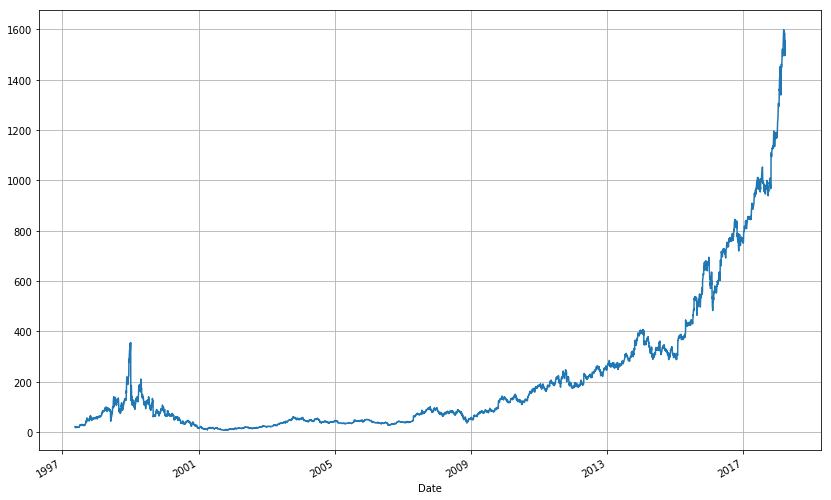

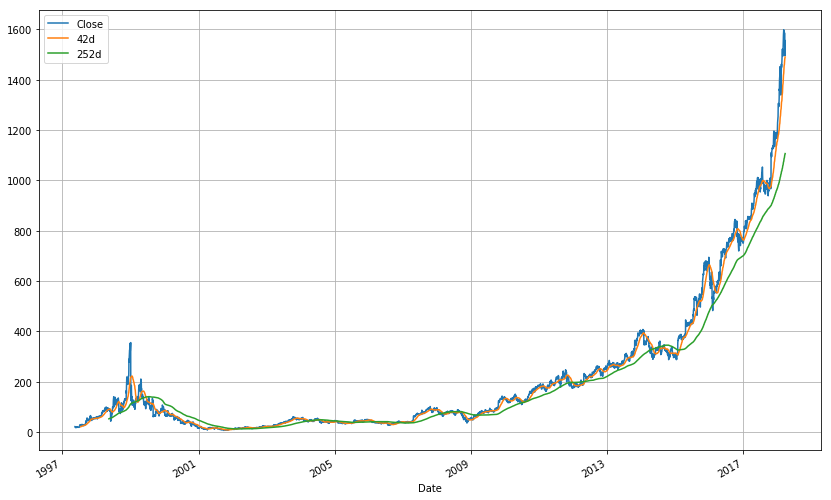

In [124]:
amazon['Close'].plot(grid=True, figsize=(14,9))

# Created 2 extra columns in our df(trend)

amazon['42d'] = np.round(amazon['Close'].rolling(42).mean(), 2)
amazon['252d'] = np.round(amazon['Close'].rolling(252).mean(), 2)
amazon['42-252']=amazon['42d'] - amazon['252d']

trend = amazon[['Close', '42d', '252d']]

trend.tail()

trend.plot(grid=True, figsize=(14, 9))



The first plot is simply the trend in stock prices of Amazon for the period duration between mid-1997 and mid-2018.

In our last plot with the strategies of moving averages(42 days and 252 days) overlapped. And now we can devise a rule to generate trading signals:

* Buy signal ( go long )
    The 42d trend is for the first time *SD points above* 252d trend.
    
* Wait ( park in cash )
    The 42d trend is within a range of +/- *SD points around* the 252d trend.
    
* Sell signal ( go short )
    The 42d trend is for the first time *SD points below* the 252d trend 
    
I need to add another column to the trend dataframe with the differences between the two trends

In accordance with the last plot, investors should be buying Amazon stock and holding on to them(42d > 252d)

In [125]:


trend = amazon['Close','42d','252d','42-252']


KeyError: ('Close', '42d', '252d', '42-252')

The new column '42-252' starts with NaNs because the 42d only gets filled for the first time after the first 42 'Close' entries and the same for the 252d respectively in terms of its entries ( only starts being recorded 1 year later ). I could remove it with dropna() pandas command, but I want to highlight where the data,the 42 day trend and 252 day trend starts on the time series axis. Otherwise they would start at the same time.

I will create another column named *regime* with an assumed value for *SD* of 50 as a threshold.


In [26]:
SD = 50
amazon['Regime'] = np.where(amazon['42-252'] > SD, 1, 0)
amazon['Regime'] = np.where(amazon['42-252'] < -SD, -1, amazon['Regime'])
amazon['Regime'].value_counts()

 0    4394
 1     818
-1      36
Name: Regime, dtype: int64

In other words, on 4,394 days the 42-day trend is more than SD points below the 252-day trend. On 818 trading days, the 42-day trend lies more than SD points above the 252-day trend.

(-1.1, 1.1)

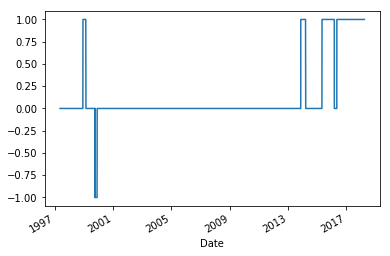

In [27]:
amazon['Regime'].plot(lw=1.5)
plt.ylim([-1.1,1.1])

Based on the regime above, an investor is either long or short in the market(benchmark) or parks his wealth in cash without any interest. The investor makes market return when **long**(1), makes the negative market return when **short**(-1), and make no returns(0) when **parks his wealth in cash**. There is a longer period of no-returns, where investors should park their cash. Also,there was little periods where Amazon stock took a dive. In the last few years(let's say 2014 onwards) it has actually provided signals for buying
To get the returns, I will use log function in Pandas

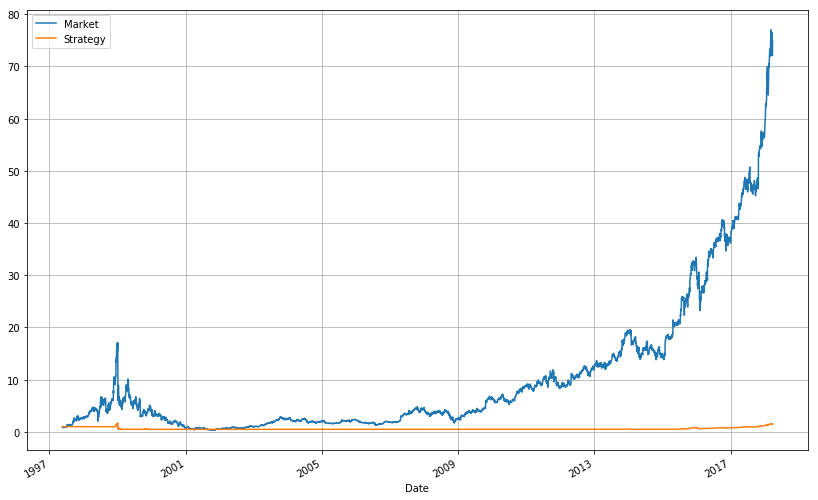

In [52]:
# Market Returns first

amazon['Market'] = np.log(amazon['Close'] / amazon['Close'].shift(1))  

# Shift method is to shift the time series by as many index entries as I want( 1 day )

# For the strategy returns Regime column.shifted by 1 day multiplied by the Returns

amazon['Strategy'] = amazon['Regime'].shift(1) * amazon['Market']

# Plot the 2 returns
amazon[['Market', 'Strategy']].cumsum().apply(np.exp).plot(grid=True,
                                                          figsize=(14,9))

<Figure size 1008x648 with 0 Axes>

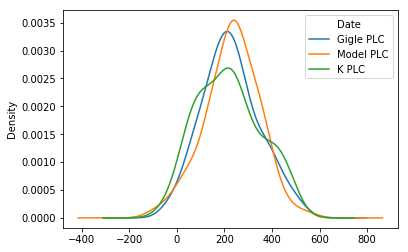

Date,Gigle PLC,Model PLC,K PLC
2002-04-06,66.207935,243.499955,406.622621
2002-04-07,188.175898,236.821105,416.698614
2002-04-08,205.540696,155.538178,109.916428
2002-04-09,252.351109,361.256543,370.295932
2002-04-10,462.061804,169.661770,281.584575


In [106]:
# Simulation starts here

dates = pd.date_range('1/1/2002', periods=100, freq='D') # I need to index date to df
 

df = pd.DataFrame(123.54 * np.random.randn(100,3) + 234.56, index=dates,
                 columns=['Gigle PLC', 'Model PLC', 'K PLC'])


df = df.rename_axis('Date', axis=1)


plt.figure(figsize=(14,9))
df.plot.density()
plt.show()

df.tail()




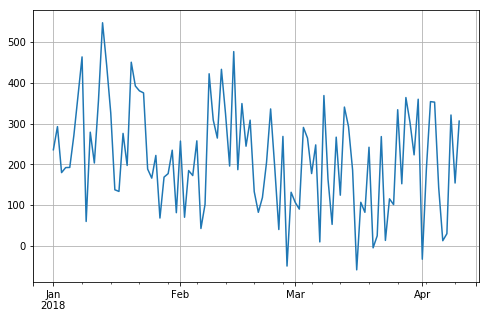

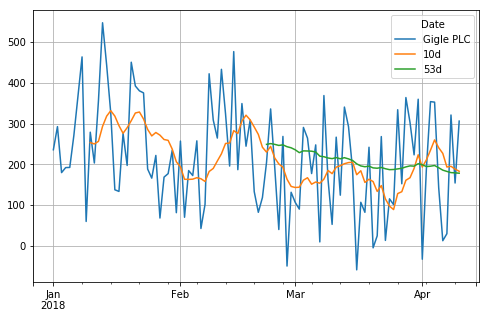

In [104]:
df['Gigle PLC'].plot(grid=True, figsize=(8,5))

# Created 2 extra columns in our df(trend)

df['10d'] = np.round(df['Gigle PLC'].rolling(10).mean(), 2)
df['53d'] = np.round(df['Gigle PLC'].rolling(53).mean(), 2)


gigle = df[['Gigle PLC', '10d', '53d']]

gigle.tail()

gigle.plot(grid=True, figsize=(8, 5))


<Figure size 1008x648 with 0 Axes>

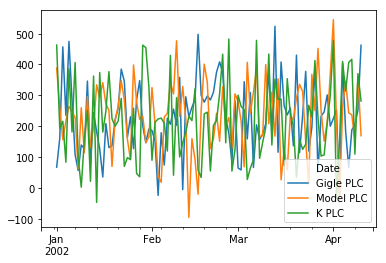

In [126]:
# Simulation of Random Walk fluctuation of stock price movements
# Adjustment of the figure must be made to place legend outside


plt.figure(figsize=(14,9))
df.plot()
plt.show()





In [ ]:
index = pd.date_range('1/1/2019', periods=100, freq='D') # I need to index date to df

columns = pd.MultiIndex.from_product([['Sample PLC', 'Model PLC'],['Closing', 'Returns']]) 

data = 277.23 * np.random.randn(100, 4 ) + 208.74

Sample PLC['Closing'] =278 * np.random.randn(100, 4) + 209
Model PLC['Closing'] =278 * np.random.randn(100, 4) + 209

Sample PLC['Returns'] =  np.log(Sample PLC.Close).diff()

Model PLC['Returns'] =  np.log(Model PLC.Close).diff()

df = pd.DataFrame(

In [122]:


trend.tail()

AttributeError: 'NoneType' object has no attribute 'tail'

In the figure above we see and compare stock price fluctuations of 4 imaginary companies with a random normal distribution with a mean close to 0. This is a representation of the 'Close Stock Price' in percentual points. The range depicted is from -3 to 3 ( standard deviations ) with 0 ( as the mean )
I based this simulation on Amazon stock prices ( 'Closing' ) from 1997-05-16 until 2018-03-27. My simulation is for 100 days,from 2019-01-01 until 2019-04-10

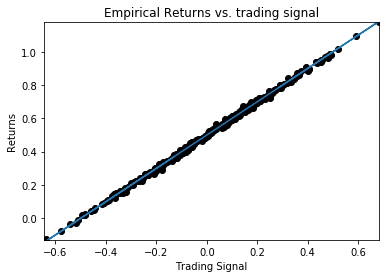

In [82]:
N = 300
X = 0.25 * np.random.randn(N)
Y = 0.5 + X + 0.01 * np.random.randn(N)

ls_coef_ = np.cov(X,Y) [0,1] /np.var(X)
ls_intercept = Y.mean() - ls_coef_ * X.mean()

plt.scatter(X,Y, c="k")
plt.xlabel("Trading Signal")
plt.ylabel("Returns")
plt.title("Empirical Returns vs. trading signal")
plt.plot(X, ls_coef_ * X + ls_intercept, label="least squares line")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())

plt.show()
                                   
                                                                     
                                       
                                       
                                       
        

